In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
sns.set_style('darkgrid')

from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoModel, AlbertTokenizerFast

from data import SNLICrossEncoderDataset, SNLIBiEncoderDataset
from data.utils import get_data, collate_fn, collate_fn_biencoder

from model import NLICrossEncoder, NLIBiEncoder

from training import Trainer
from training.utils import unfreeze_parameters

# Data

In [2]:
train, test, val = get_data('snli_1.0')

In [3]:
LABELS = ['entailment', 'contradiction', 'neutral']
NUM_LABELS = len(LABELS)

train = train[train.target.isin(set(LABELS))]
val = val[val.target.isin(set(LABELS))]
test = test[test.target.isin(set(LABELS))]

In [4]:
train.head()

,sentence1,sentence2,target
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [5]:
target2idx = {l: i for i, l in enumerate(LABELS)}
train.target = train.target.map(target2idx)
val.target = val.target.map(target2idx)
test.target = test.target.map(target2idx)

In [6]:
albert_tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

In [7]:
train_dataset = SNLIBiEncoderDataset(albert_tokenizer, train.sentence1.tolist(), train.sentence2.tolist(), train.target.tolist())
val_dataset = SNLIBiEncoderDataset(albert_tokenizer, val.sentence1.tolist(), val.sentence2.tolist(), val.target.tolist())

In [8]:
train_loader = DataLoader(train_dataset, batch_size=56, shuffle=True, collate_fn=collate_fn_biencoder)
val_loader = DataLoader(val_dataset, batch_size=56, shuffle=False, collate_fn=collate_fn_biencoder)

# Model

In [9]:
albert = AutoModel.from_pretrained('albert-base-v2')

In [10]:
model = NLIBiEncoder(albert, NUM_LABELS, lambda x: x.pooler_output)

In [11]:
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model, criterion, 'albert/v2/albert_snli.pt', 'albert/v2/albert_optimizer.pt', lr=1e-4, device='cuda:0')

# Training

In [12]:
trainer.train(train_loader, val_loader, num_epochs=30, frozen_encoder_epochs=1)

Epoch 1/30:


Mean loss: 1.0950402116775513. Current progress: : 100%|██████████| 9811/9811 [15:51<00:00, 10.32it/s]


Mean training loss: 1.0956908001008838. Mean validation loss: 1.0945669879967517.
Training accuracy: 0.3446330048947243. Validation accuracy: 0.35555781758957655.
Epoch 2/30:


Mean loss: 0.656751152575016. Current progress: : 100%|██████████| 9811/9811 [39:05<00:00,  4.18it/s] 


Mean training loss: 0.7362053868554562. Mean validation loss: 0.6100784162567421.
Training accuracy: 0.6811129900412657. Validation accuracy: 0.7480659609120521.
Epoch 3/30:


Mean loss: 0.5746892230510712. Current progress: : 100%|██████████| 9811/9811 [38:27<00:00,  4.25it/s]  


Mean training loss: 0.6072786379031797. Mean validation loss: 0.5426340380852873.
Training accuracy: 0.7536237160222583. Validation accuracy: 0.7865431596091205.
Epoch 4/30:


Mean loss: 0.5303758757114411. Current progress: : 100%|██████████| 9811/9811 [38:26<00:00,  4.25it/s]


Mean training loss: 0.5414941800976004. Mean validation loss: 0.5098353816534985.
Training accuracy: 0.7850689975917738. Validation accuracy: 0.7994706840390879.
Epoch 5/30:


Mean loss: 0.49742590260505676. Current progress: : 100%|██████████| 9811/9811 [39:01<00:00,  4.19it/s]


Mean training loss: 0.4956798625762717. Mean validation loss: 0.4919486805288629.
Training accuracy: 0.8067521347296069. Validation accuracy: 0.8070032573289903.
Epoch 6/30:


Mean loss: 0.4597811028063297. Current progress: : 100%|██████████| 9811/9811 [40:08<00:00,  4.07it/s] 


Mean training loss: 0.45451905428391204. Mean validation loss: 0.4901229847561229.
Training accuracy: 0.8253681054741184. Validation accuracy: 0.805985342019544.
Epoch 7/30:


Mean loss: 0.4355667892098427. Current progress: : 100%|██████████| 9811/9811 [39:16<00:00,  4.16it/s] 


Mean training loss: 0.4291330353906427. Mean validation loss: 0.4904645195400173.
Training accuracy: 0.8368740750718554. Validation accuracy: 0.8114820846905537.
Epoch 8/30:


Mean loss: 0.4040231667160988. Current progress: : 100%|██████████| 9811/9811 [39:41<00:00,  4.12it/s] 


Mean training loss: 0.40214941973454627. Mean validation loss: 0.49525157116692176.
Training accuracy: 0.8480924409365688. Validation accuracy: 0.810057003257329.
Epoch 9/30:


Mean loss: 0.381740692794323. Current progress: : 100%|██████████| 9811/9811 [39:35<00:00,  4.13it/s]  


Mean training loss: 0.3736388676454017. Mean validation loss: 0.5152806570245461.
Training accuracy: 0.8603756687241862. Validation accuracy: 0.8034405537459284.
Validation performance has started degrading. Performing early stopping.


NLIBiEncoder(
  (encoder): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
      

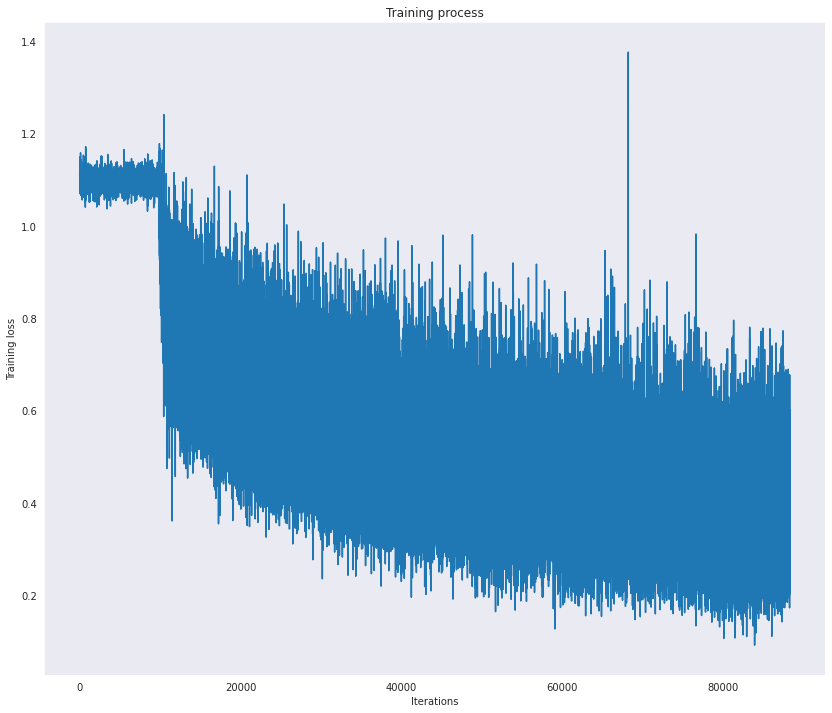

In [13]:
plt.figure(figsize=(14, 12))
plt.plot(trainer.train_losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Training loss');

The observed loss dynamics suggest our model would benefit from a larger batch size. Also, training the model for one epoch with the encoder frozen clearly did not produce any meaningful results.